#### Adapted from "image Classification With Transfer Learning in Keras" in coursera: https://www.coursera.org/learn/image-classification-transfer-learning-keras/home/welcome

# Image Classification With Transfer Learning in Keras

# Task 1: Importing Libraries

In [2]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


# Task 2: Cats vs Dogs Dataset

In [3]:
pets.download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [4]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples count:', count_train)
print('Test examples count:', count_test)

Training examples count: 3680
Test examples count: 3669


# Task 3: Get Random Batch

#### We want to write a function that returns randomly selected images from annotation dictionary

In [24]:
image_dir = 'data/images/'

def get_random_batch(annot, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    indices = np.random.choice(range(total_examples), batch_size, replace=True)
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images = []
    
    for i, index in enumerate(indices):
        image_path = os.path.join(image_dir, all_keys[index])
        image = tf.keras.preprocessing.image.load_img(
            image_path, target_size=(128, 128) # we don't need to enter channel information
        )
        
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0) # adding one dimensions for number of images in a badge, this step is not needed
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]
        images.append(image)
    return x, y, images

Displaying first 8 examples..


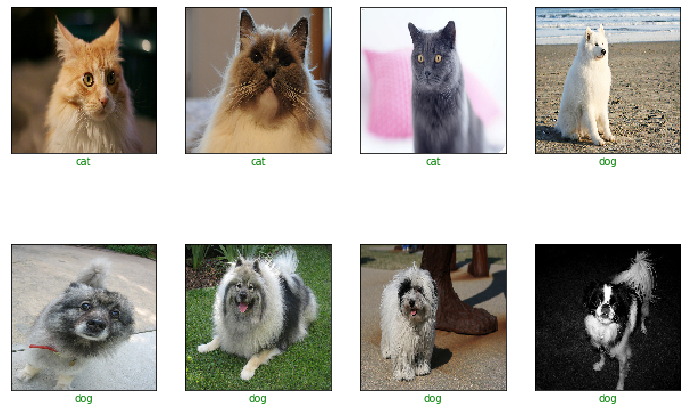

In [27]:
x, y, images = get_random_batch(train_annot, batch_size=8)
pets.display_examples(x, y, y, images, index_to_class).show() # second y is for predictions which we don't have any at this step

# Task 4: Create Model

In [15]:
# we don't need the final fully connected layer of MobileNet so include_top should be equal to False
# Final layer of convolutional block will be converted from 4D to 2D for input of our fully connected layer
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=(128, 128, 3),
                                                     pooling='avg', weights='imagenet')
#mnet.summary()

#### We need to create the full model with fully connected layer and binary classification

In [29]:
def create_model():
    model = tf.keras.models.Sequential([
        mnet,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.layers[0].trainable = False # We don't train the weights from the Mobile net
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Task 5: Model Training

In [43]:
# this function generates endless stream of data and is used in fit genrator method
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        yield (x, y)

In [44]:
batch_size = 32
steps_per_epoch = int(len(list(train_annot.keys()))/batch_size)
validation_steps = int(len(list(test_annot.keys()))/batch_size)

print('Steps per epoch:', steps_per_epoch)
print('Validation steps:', validation_steps)

Steps per epoch: 115
Validation steps: 114


In [42]:
%%time

_ = model.fit(
    data_generator(batch_size, train_annot),
    validation_data=data_generator(batch_size, test_annot),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=1
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 115 steps, validate for 114 steps
115/115 [==============================] - 135s 1s/step - loss: 0.2439 - acc: 0.9019 - val_loss: 0.0896 - val_acc: 0.9775
Wall time: 2min 15s


# Task 6: Predictions

Displaying first 8 examples..


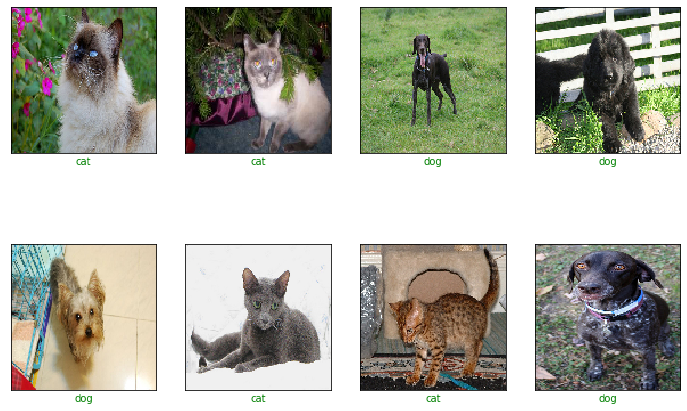

In [45]:
x, y, images = get_random_batch(test_annot, batch_size=8)
preds = model.predict(x)
pets.display_examples(x, y, preds, images, index_to_class).show()